# Overview
The project involves contributors evaluating tweets related to various brands and products. The crowd is tasked with determining whether each tweet expresses positive, negative, or neutral emotions towards a brand and/or product mentioned. Additionally, if there is emotional content, contributors are asked to identify which specific brand or product is being targeted.

# Business Understanding
Understanding public sentiment towards brands and products is crucial for businesses to gauge their reputation, assess customer satisfaction, and identify areas for improvement. Analyzing social media data like tweets provides valuable insights into consumer opinions and preferences.

# Data Understanding
The dataset contains 9093 rows of tweets related to multiple brands and products. Each tweet is annotated by contributors to indicate the sentiment expressed (positive, negative, or neutral) and specify the brand or product targeted by the emotion.

# Main Objective
The main objective of the project is to analyze the sentiment of tweets towards various brands and products. By categorizing the sentiment as positive, negative, or neutral and identifying the specific targets of emotions, the aim is to gain insights into consumer perceptions and attitudes.

## Specific Objectives:

1.Classify each tweet as expressing positive, negative, or neutral sentiment towards brands and products.

2.Identify the specific brands or products targeted by the emotional content in each tweet.

3.Analyze the overall sentiment distribution across brands and products.

4.Explore patterns and trends in consumer sentiment over time or in response to specific events or marketing campaigns.


In [2]:
#import libraries
import pandas as pd 
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from sklearn.model_selection import train_test_split
# from mlxtend.plotting import plot_confusion_matrix
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
import string
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ronal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ronal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# load the dataset
data = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding='ISO-8859-1')

data.head(5)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


## EXPLORE THE DATASET

In [4]:
#checking the data shape

data.shape

(9093, 3)

In [5]:
# Get summary statistics
print(data.describe())

                                               tweet_text  \
count                                                9092   
unique                                               9065   
top     RT @mention Marissa Mayer: Google Will Connect...   
freq                                                    5   

       emotion_in_tweet_is_directed_at  \
count                             3291   
unique                               9   
top                               iPad   
freq                               946   

       is_there_an_emotion_directed_at_a_brand_or_product  
count                                                9093  
unique                                                  4  
top                    No emotion toward brand or product  
freq                                                 5389  


In [6]:
#checking columns
data.columns

Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directed_at_a_brand_or_product'],
      dtype='object')

In [7]:
#checking missing values
print("Missing Values:\n", data.isnull().sum())

Missing Values:
 tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64


The column "tweet_text" has 1 missing value, and the column "emotion_in_tweet_is_directed_at" has 5802 missing values. The column "is_there_an_emotion_directed_at_a_brand_or_product" has 0 missing values.

In [8]:

# replace NaN values in 'tweet_text' column 
data['tweet_text'].fillna('No text available', inplace=True)

# Replace NaN values in 'emotion_in_tweet_is_directed_at' column with a default emotion category
default_emotion = 'unknown'
data['emotion_in_tweet_is_directed_at'].fillna(default_emotion, inplace=True)


# PREPROCESSING

In [9]:
## Tokenization, lowercasing, and removing stopwords
stop_words = set(stopwords.words('english'))
data['tweet_text'] = data['tweet_text'].apply(lambda x: ' '.join([word.lower() for word in word_tokenize(x) if word.isalpha() and word.lower() not in stop_words]))


In [10]:
# Print preprocessed data
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,iphone hrs tweeting dead need upgrade plugin s...,iPhone,Negative emotion
1,jessedee know fludapp awesome app likely appre...,iPad or iPhone App,Positive emotion
2,swonderlin wait ipad also sale sxsw,iPad,Positive emotion
3,sxsw hope year festival crashy year iphone app...,iPad or iPhone App,Negative emotion
4,sxtxstate great stuff fri sxsw marissa mayer g...,Google,Positive emotion


the 'tweet_text' column has been preprocessed by tokenization, lowercasing, and removing stopwords

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9093 non-null   object
 1   emotion_in_tweet_is_directed_at                     9093 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


# Data visualization

In [12]:
# Count plot of emotions
plt.figure(figsize=(8, 6))
sns.countplot(x='is_there_an_emotion_directed_at_a_brand_or_product', data=df, hue='is_there_an_emotion_directed_at_a_brand_or_product', palette='pastel', legend=False)
plt.title('Distribution of Emotions')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


NameError: name 'df' is not defined

<Figure size 800x600 with 0 Axes>

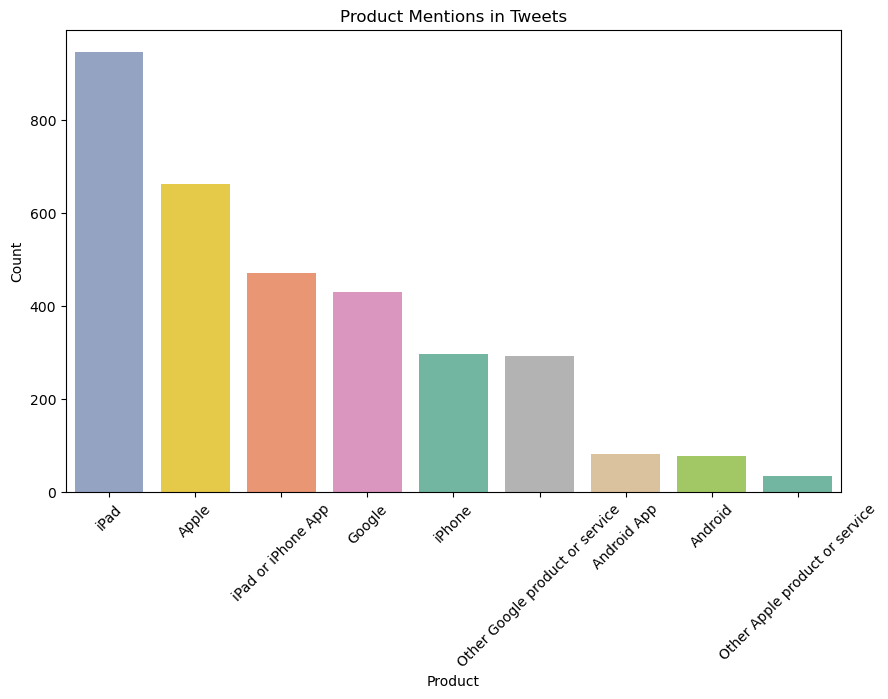

In [ ]:
# Bar plot for product counts
plt.figure(figsize=(10, 6))
sns.countplot(x='emotion_in_tweet_is_directed_at', data=df, order=df['emotion_in_tweet_is_directed_at'].value_counts().index, hue='emotion_in_tweet_is_directed_at', palette='Set2', legend=False)
plt.title("Product Mentions in Tweets")
plt.xlabel("Product")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()



# Overall sentiment distribution

In [ ]:
 #Calculate overall sentiment distribution
sentiment_distribution = data['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()
print("Overall Sentiment Distribution:")
print(sentiment_distribution)

Overall Sentiment Distribution:
is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64


This is the general overview of sentiment trends 

# Most mentioned brand or product

In [ ]:
#Identify most mentioned brands/products
most_mentioned = data['emotion_in_tweet_is_directed_at'].value_counts().head(10)
print("\nTop 10 Mentioned Brands/Products:")
print(most_mentioned)


Top 10 Mentioned Brands/Products:
emotion_in_tweet_is_directed_at
unknown                            5802
iPad                                946
Apple                               661
iPad or iPhone App                  470
Google                              430
iPhone                              297
Other Google product or service     293
Android App                          81
Android                              78
Other Apple product or service       35
Name: count, dtype: int64


By examining the top 10 most mentioned brands or products, businesses can identify which ones are receiving the most attention or discussion on social media platforms.

# Sentiment distribution for each brand or product

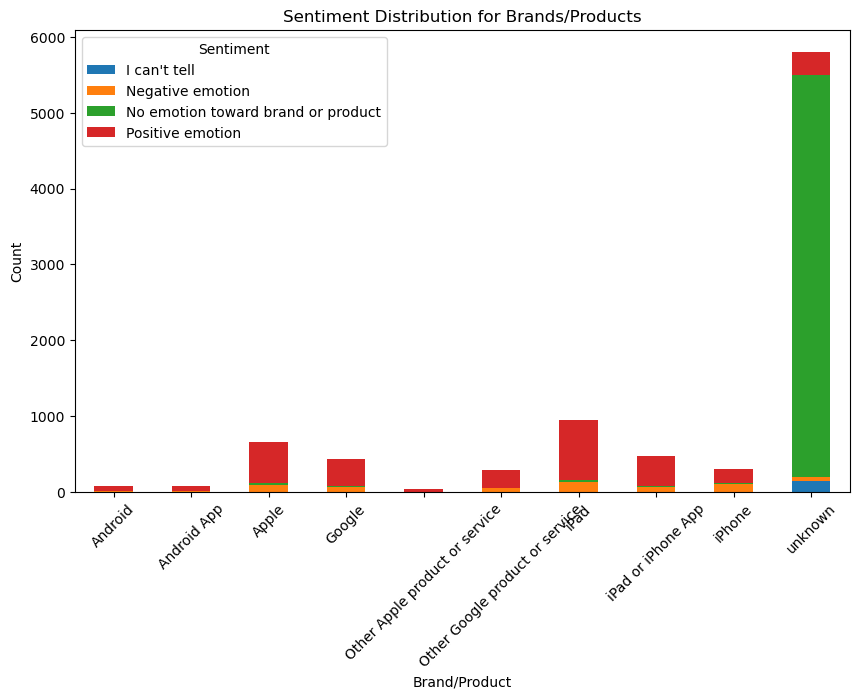

In [ ]:
# Sentiment distribution for each brand/product
brand_sentiment = data.groupby(['emotion_in_tweet_is_directed_at', 'is_there_an_emotion_directed_at_a_brand_or_product']).size().unstack(fill_value=0)
brand_sentiment.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Sentiment Distribution for Brands/Products")
plt.xlabel("Brand/Product")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.show()

The plot provides a visual representation of the sentiment distribution across different brands or products to allow us grasp sentiment trends across the brands or products.

In [13]:
#loading dataset
df = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding='latin1')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [14]:
df['emotion_in_tweet_is_directed_at'].value_counts()

emotion_in_tweet_is_directed_at
iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: count, dtype: int64

In [15]:
apple_keywords = ['apple', 'iphone', 'ipad', 'mac', 'ios','itunes']
google_keywords = ['google', 'android', 'pixel', 'chromebook','android','samsung']

# Function to check if a tweet contains keywords related to Apple or Google
def check_product(tweet):
    if isinstance(tweet, str):
        tweet_lower = tweet.lower()
        if any(keyword in tweet_lower for keyword in apple_keywords):
            return 'Apple'
        elif any(keyword in tweet_lower for keyword in google_keywords):
            return 'Google'
    return None

null_rows = df[df['emotion_in_tweet_is_directed_at'].isnull()]
null_rows['emotion_in_tweet_is_directed_at'] = null_rows['tweet_text'].apply(check_product)
df.update(null_rows)
df['emotion_in_tweet_is_directed_at'].isnull().sum()

700

In [16]:
# Successfully renamed the column for our convenience.
df.rename(columns={'emotion_in_tweet_is_directed_at':'emotion_towards','is_there_an_emotion_directed_at_a_brand_or_product':'emotion_reaction'},inplace=True)

In [17]:
df.head()

,tweet_text,emotion_towards,emotion_reaction
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [18]:
#explore the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   tweet_text        9092 non-null   object
 1   emotion_towards   8393 non-null   object
 2   emotion_reaction  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [19]:
df.isnull().sum()  # check missing values

tweet_text            1
emotion_towards     700
emotion_reaction      0
dtype: int64

tweet_text: There is 1 missing value in the "tweet_text" column.
emotion_towards: There are 5802 missing values in the "emotion_towards" column.
emotion_reaction: There are no missing values (0) in the "emotion_reaction" column.

In [20]:
product_counts = df['emotion_towards'].value_counts()
print("\nProduct counts:")
print(product_counts)


Product counts:
emotion_towards
Apple                              3869
Google                             2324
iPad                                946
iPad or iPhone App                  470
iPhone                              297
Other Google product or service     293
Android App                          81
Android                              78
Other Apple product or service       35
Name: count, dtype: int64


In [21]:
# filling the null values
df.dropna(inplace=True)

In [22]:
# check if there is any missing values
df.isnull().sum()

tweet_text          0
emotion_towards     0
emotion_reaction    0
dtype: int64

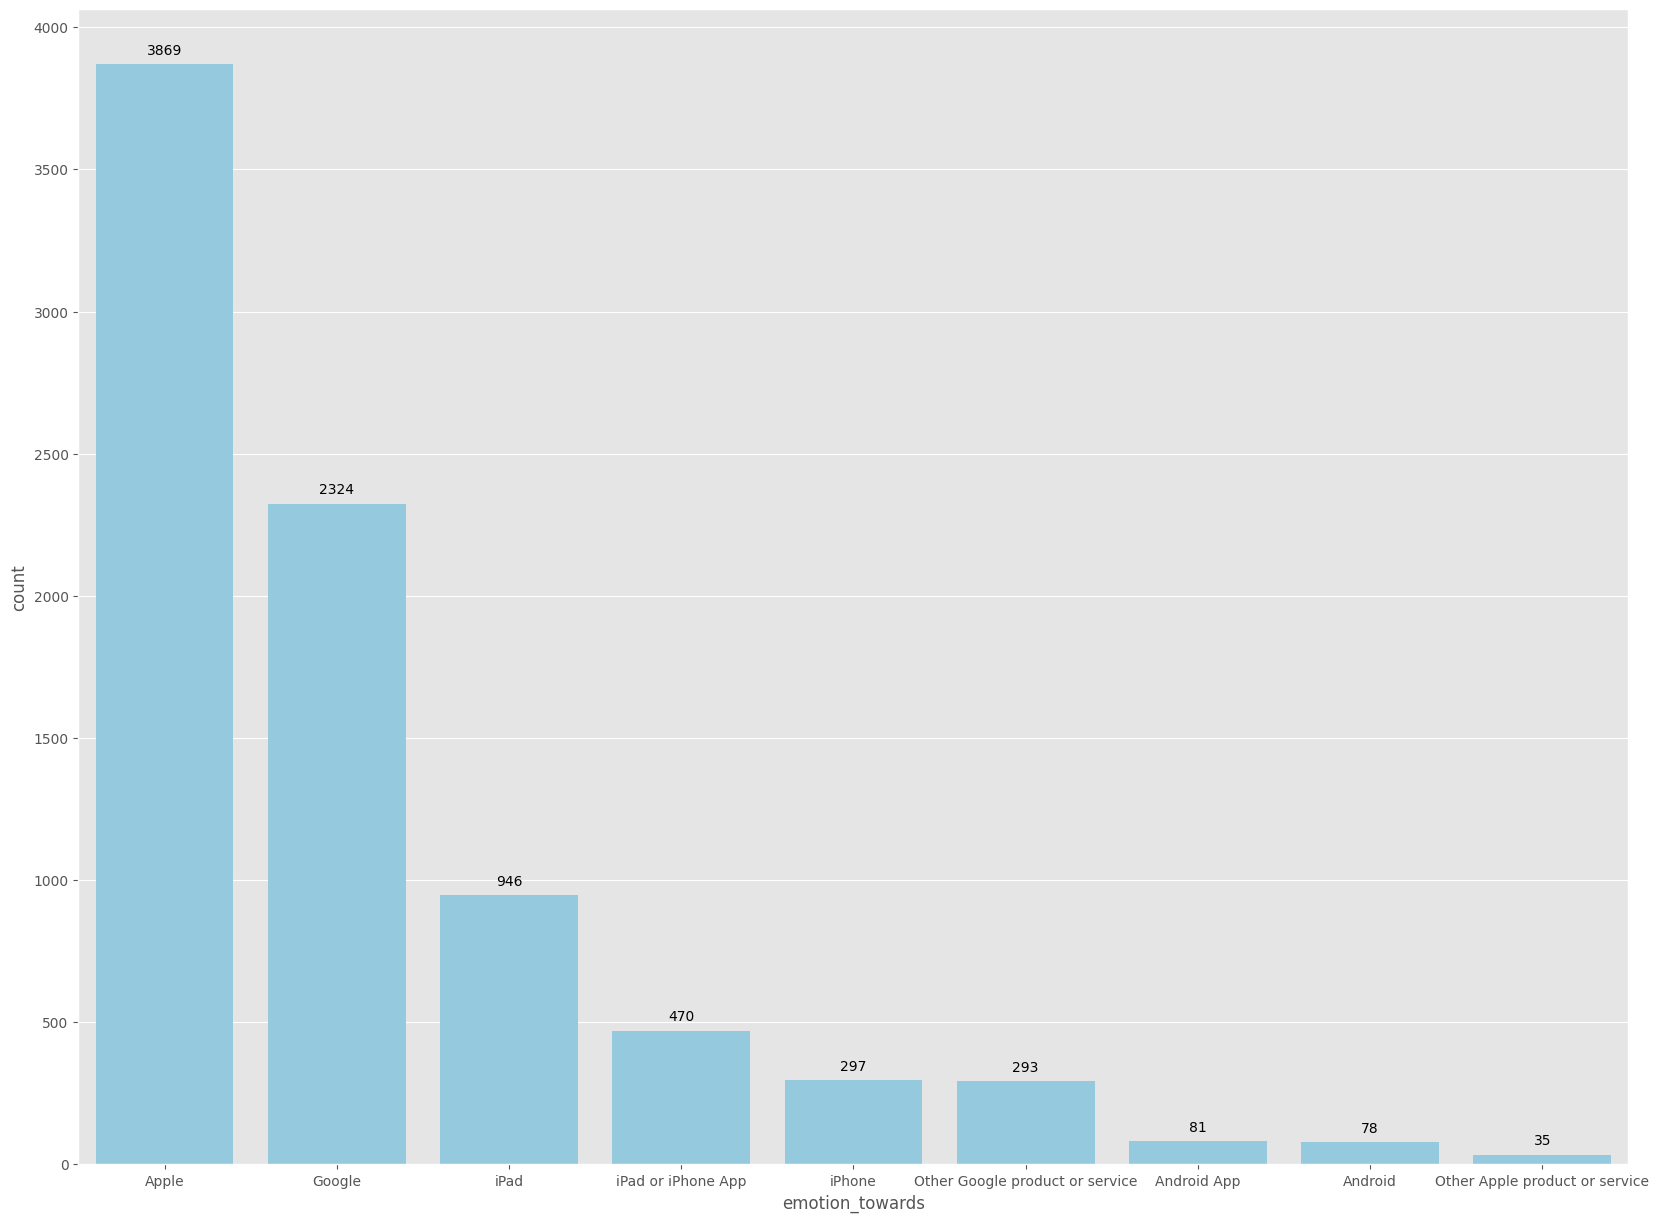

In [23]:
# Sort the DataFrame by the count of 'emotion_towards' in ascending order
sorted_df = df['emotion_towards'].value_counts().reset_index(name='count').sort_values(by='count', ascending=False)

# Plot
plt.figure(figsize=(20, 15))
ax = sns.countplot(x='emotion_towards', data=df, order=sorted_df['emotion_towards'], color='skyblue')

# Add data labels
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

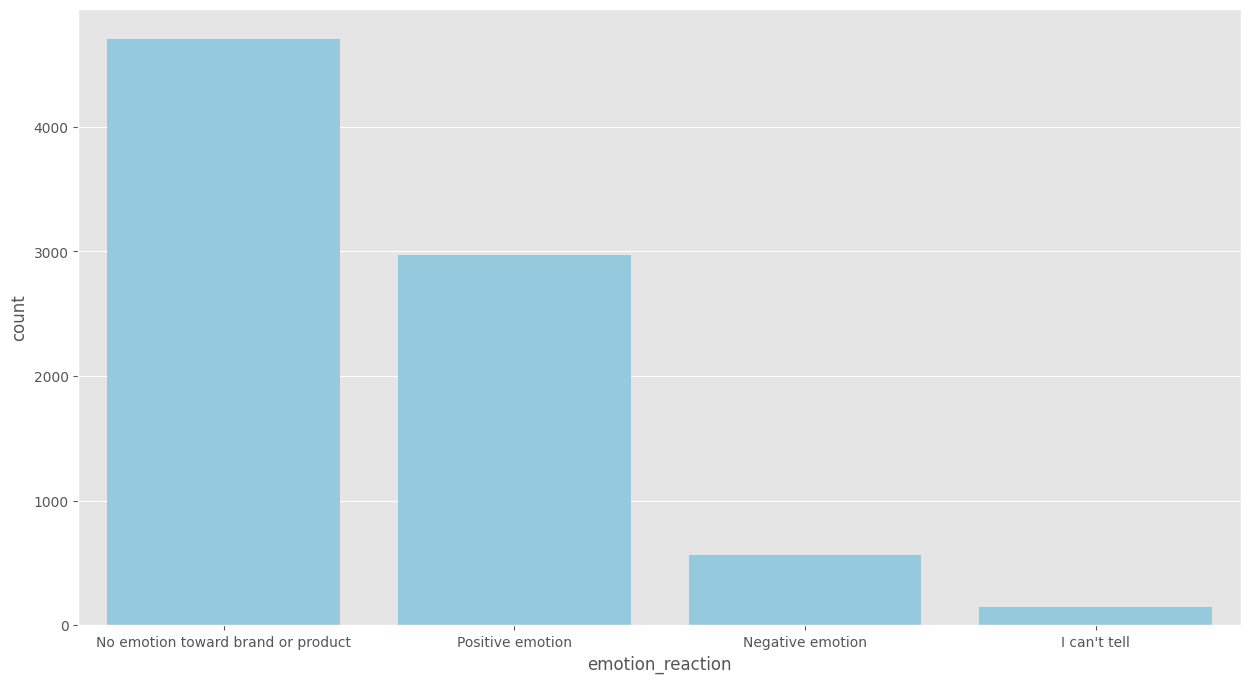

In [24]:
# Sort the DataFrame by the count of 'emotion_reaction' in descending order
sorted_df = df['emotion_reaction'].value_counts().reset_index(name='count').sort_values(by='count', ascending=False)

# Plot
plt.figure(figsize=(15, 8))
sns.countplot(x='emotion_reaction', data=df, order=sorted_df['emotion_reaction'], color='skyblue')
plt.show()

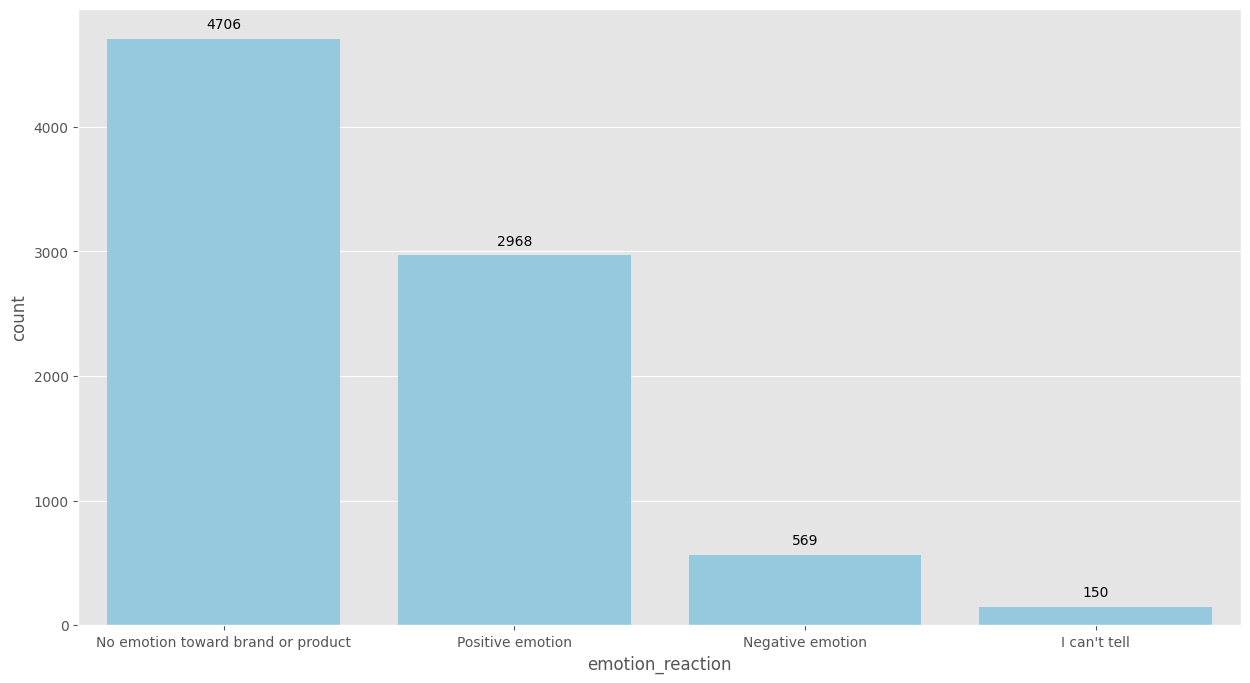

In [25]:
#  The count of 'emotion_reaction' in descending order
sorted_df = df['emotion_reaction'].value_counts().reset_index(name='count').sort_values(by='count', ascending=False)

# Plot
plt.figure(figsize=(15, 8))
ax = sns.countplot(x='emotion_reaction', data=df, order=sorted_df['emotion_reaction'], color='skyblue')

# Add data labels
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

plt.show()

<Figure size 2500x2000 with 0 Axes>

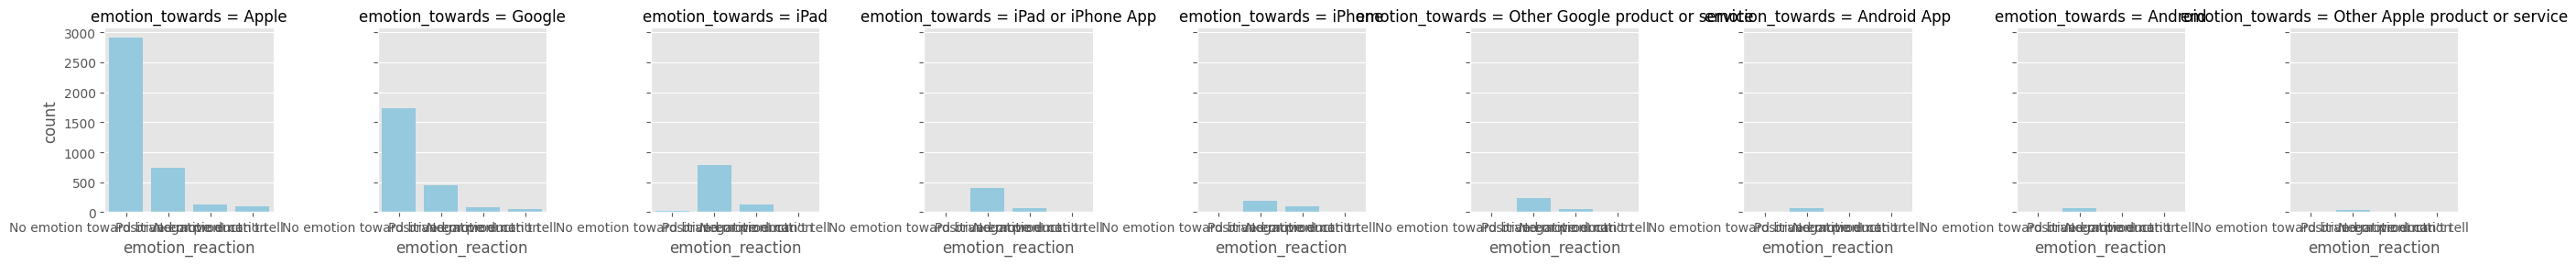

In [26]:
# Sort the DataFrame by the count of 'emotion_towards' in descending order
sorted_df = df['emotion_towards'].value_counts().reset_index(name='count').sort_values(by='count', ascending=False)

# Plot
plt.figure(figsize=(25, 20))
g = sns.FacetGrid(df, col="emotion_towards", col_order=sorted_df['emotion_towards'])
g.map(sns.countplot, "emotion_reaction", order=df['emotion_reaction'].value_counts().index, color='skyblue')
plt.show()

In [27]:
df.describe()

,tweet_text,emotion_towards,emotion_reaction
count,8393,8393,8393
unique,8368,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,Apple,No emotion toward brand or product
freq,5,3869,4706


In [28]:
no_emotion_tweets = df[df['emotion_reaction'] == 'emotion_towards']['tweet_text']
no_emotion_tweets.count()

0

In [29]:
# Get unique emotions
unique_emotions = df['emotion_reaction'].unique()
unique_emotions

array(['Negative emotion', 'Positive emotion',
       'No emotion toward brand or product', "I can't tell"], dtype=object)

In [30]:
# Get counts of each emotion
emotion_counts = df['emotion_reaction'].value_counts()
# Sort emotions from highest to lowest
sorted_emotions = emotion_counts.sort_values(ascending=False)
sorted_emotions

emotion_reaction
No emotion toward brand or product    4706
Positive emotion                      2968
Negative emotion                       569
I can't tell                           150
Name: count, dtype: int64

In [31]:
df.columns

Index(['tweet_text', 'emotion_towards', 'emotion_reaction'], dtype='object')

In [32]:
unique_products = df['emotion_towards'].unique()
print("Unique products mentioned:")
print(unique_products)

Unique products mentioned:
['iPhone' 'iPad or iPhone App' 'iPad' 'Google' 'Apple' 'Android'
 'Android App' 'Other Google product or service'
 'Other Apple product or service']


In [33]:
product_counts = df['emotion_towards'].value_counts()
print("\nProduct counts:")
print(product_counts)


Product counts:
emotion_towards
Apple                              3869
Google                             2324
iPad                                946
iPad or iPhone App                  470
iPhone                              297
Other Google product or service     293
Android App                          81
Android                              78
Other Apple product or service       35
Name: count, dtype: int64


In [34]:
ipad_tweets = df[df['emotion_towards'] == 'iPad']['tweet_text']
print("\nRelevant tweets mentioning iPad:")
print(ipad_tweets.head())


Relevant tweets mentioning iPad:
2     @swonderlin Can not wait for #iPad 2 also. The...
20    Need to buy an iPad2 while I'm in Austin at #s...
25    RT @LaurieShook: I'm looking forward to the #S...
36    The best!  RT @mention Ha! First in line for #...
57    {link} RT @mention 1st stop on the #SXSW #Chao...
Name: tweet_text, dtype: object


In [35]:
ipad_tweets = df[df['emotion_towards'] == 'iPad']['tweet_text']
ipad_tweets

2       @swonderlin Can not wait for #iPad 2 also. The...
20      Need to buy an iPad2 while I'm in Austin at #s...
25      RT @LaurieShook: I'm looking forward to the #S...
36      The best!  RT @mention Ha! First in line for #...
57      {link} RT @mention 1st stop on the #SXSW #Chao...
                              ...                        
9063    @mention You should get the iPad 2  to save yo...
9070    You know you've made it to #sxsw when you see ...
9071    what are your essentials for #SxSW?  Mine? poc...
9079    &quot;papyrus...sort of like the ipad&quot; - ...
9088                        Ipad everywhere. #SXSW {link}
Name: tweet_text, Length: 946, dtype: object

The dataframe has 9093 rows and 3 columns. 
All the data is of the object type which normally represents text or categorical data

The columns are named:
tweet_text 
    -contains 9092 non-null entries of text data (ie tweets)
emotion_in_tweet_is_directed_at 
    - Represents the emotion attached to a specific brand or product (e.g., “iPad”).
    - There are 3291 non-null entries.
    - The most frequent value is “iPad” (appears 946 times)
is_there_an_emotion_directed_at_a_brand_or_product
    -Indicates whether there is an emotion directed at a brand or product.
    -Four possible values:
        “Positive emotion”, “Negative emotion”,“No emotion toward brand or product” (appears 5389 times),“I can’t tell”
        


In [36]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def clean_text(text):
    
    text = text.lower()
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize the text into words
    words = word_tokenize(text)
    
    # Remove stopwords and numbers
    stop_words = set(stopwords.words('english'))
    clean_words = [word for word in words if word not in stop_words and not word.isdigit()]
    
    # Join the cleaned words back into a single string
    cleaned_text = ' '.join(clean_words)
    
    return cleaned_text


In [37]:
nltk.download('stopwords')
stopwords_list = stopwords.words('english')
import string
stopwords_list += string.punctuation
st = nltk.PorterStemmer()
def stemming(content):
    stemmed_content = re.sub('[^a-zA-z]',' ',content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [st.stem(word) for word in stemmed_content if word not in stopwords_list]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content
df['stemmed_tweets'] = df['tweet_text'].apply(stemming)
df['stemmed_tweets'].head()



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ronal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    wesley g iphon hr tweet rise_austin dead need ...
1    jessede know fludapp awesom ipad iphon app lik...
2                  swonderlin wait ipad also sale sxsw
3     sxsw hope year festiv crashi year iphon app sxsw
4    sxtxstate great stuff fri sxsw marissa mayer g...
Name: stemmed_tweets, dtype: object

In [38]:
df['emotion_reaction'].value_counts()

emotion_reaction
No emotion toward brand or product    4706
Positive emotion                      2968
Negative emotion                       569
I can't tell                           150
Name: count, dtype: int64

Lets drop 'I cant tell'

In [39]:
# Create a boolean mask to identify rows where the 'emotion' column contains 'I can't tell'
mask = df['emotion_reaction'] != "I can't tell"

# Apply the mask to filter out rows where the 'emotion' column contains 'I can't tell'
df_filtered = df[mask]

df_filtered.reset_index(drop=True, inplace=True)


In [40]:
df_filtered['emotion_reaction'].value_counts()

emotion_reaction
No emotion toward brand or product    4706
Positive emotion                      2968
Negative emotion                       569
Name: count, dtype: int64

we remove no emotion too

In [41]:
df_filtered['emotion_reaction'] = df_filtered['emotion_reaction'].replace({'Positive emotion':1,'Negative emotion':0})
df_filtered['emotion_reaction'].value_counts()

emotion_reaction
No emotion toward brand or product    4706
1                                     2968
0                                      569
Name: count, dtype: int64

Split Data to X and Y for modelling

In [42]:

# List of Apple products and apps
apple_products_and_apps = ['Apple', 'iPad', 'iPhone', 'iPad or iPhone App', 'Other Apple product or service']

# List of Google products and apps
google_products_and_apps = ['Google', 'Android', 'Android App', 'Other Google product or service']

# Combine both lists
products_and_apps_to_include = apple_products_and_apps + google_products_and_apps

# Create a regular expression pattern from the combined list
pattern = '|'.join(products_and_apps_to_include)

# Filter rows where the 'emotion_towards' column contains the specified products and apps
df_filtered = df_filtered[df_filtered['emotion_towards'].str.contains(pattern)]

# Display the filtered DataFrame
df_filtered.head()


,tweet_text,emotion_towards,emotion_reaction,stemmed_tweets
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,0,wesley g iphon hr tweet rise_austin dead need ...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,1,jessede know fludapp awesom ipad iphon app lik...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,1,swonderlin wait ipad also sale sxsw
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,0,sxsw hope year festiv crashi year iphon app sxsw
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,1,sxtxstate great stuff fri sxsw marissa mayer g...


Clean text

In [43]:
df_filtered['stemmed_tweets'] = df_filtered['stemmed_tweets'].apply(clean_text)
df_filtered.head()

,tweet_text,emotion_towards,emotion_reaction,stemmed_tweets
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,0,wesley g iphon hr tweet rise_austin dead need ...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,1,jessede know fludapp awesom ipad iphon app lik...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,1,swonderlin wait ipad also sale sxsw
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,0,sxsw hope year festiv crashi year iphon app sxsw
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,1,sxtxstate great stuff fri sxsw marissa mayer g...


In [44]:
null_rows = df_filtered.copy()

In [45]:
# Create a boolean mask to identify rows where the 'emotion' column contains 'I can't tell'
mask = df_filtered['emotion_reaction'] != "No emotion toward brand or product"

df_filtered.drop(df_filtered[~mask].index, inplace=True)

df_filtered['emotion_reaction'].value_counts()

emotion_reaction
1    2968
0     569
Name: count, dtype: int64

In [46]:
X = df['stemmed_tweets'].values
Y = df['emotion_reaction'].values
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,stratify=Y,random_state=42)

In [47]:
print(X_test)

['rt mention appl popup store sxsw link'
 'smartphon breakdown sxsw unoffici iphon android blackberri symbian window'
 'rt mention updat npr music iphon app song info song amp live video stream time sxsw link'
 ... 'realli like sxsw iphon app thank make event app appear work well'
 'rt mention appl intel genentech atari cisco quot someth ventur quot trace risk taker wrote check link sxsw'
 'googl circl loom googl nerd get social sxsw mention link via mention']


Convert to numerical data

In [48]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)


In [49]:
print(X_train)

  (0, 3141)	0.08257909626321848
  (0, 5265)	0.044417544135926544
  (0, 5498)	0.1931840659475964
  (0, 5145)	0.2926368072091857
  (0, 5848)	0.23066520832100754
  (0, 3156)	0.24888183838558842
  (0, 188)	0.15625690281343316
  (0, 2726)	0.27523622180276436
  (0, 4992)	0.6050818367679747
  (0, 244)	0.14367360444170255
  (0, 2799)	0.11950359933426825
  (0, 3562)	0.23991499094167626
  (0, 3727)	0.37397498815570424
  (0, 5768)	0.23338347496846204
  (1, 5525)	0.29845165991386524
  (1, 4138)	0.3589808527320949
  (1, 953)	0.2853183150487382
  (1, 775)	0.32590934325600107
  (1, 3633)	0.30962806113968633
  (1, 4955)	0.2875222809421935
  (1, 3639)	0.24851351593814736
  (1, 3269)	0.34343175529808456
  (1, 3050)	0.2704801551177176
  (1, 2281)	0.17674375231564318
  (1, 4586)	0.18084133997066476
  :	:
  (6711, 3385)	0.08139067314995208
  (6711, 3141)	0.09118118134214927
  (6711, 5265)	0.04904442322450997
  (6711, 244)	0.15863977172772856
  (6711, 2799)	0.13195202969048303
  (6712, 5733)	0.4105565076724

Training the LogReg model

In [50]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train,y_train)


LogisticRegression(max_iter=1000)

In [51]:
df_filtered['emotion_reaction'].value_counts()

emotion_reaction
1    2968
0     569
Name: count, dtype: int64

In [52]:
y_pred = model.predict(X_train)
train_data_accuracy = accuracy_score(y_train,y_pred)
y_pred_test = model.predict(X_test)
test_data_accuracy = accuracy_score(y_test,y_pred_test)
print(f'Test Data Accuracy Score: {test_data_accuracy * 100} % \n Train Data Accuracy Score: {train_data_accuracy*100} %')

Test Data Accuracy Score: 66.46813579511614 % 
 Train Data Accuracy Score: 78.52249031873697 %


In [53]:
# Example tweet text
tweet_text = ".@wesley83 I have a 3G iPhone. After 3 hrs twe..."

# Print original tweet text
print("Original Text:", tweet_text)

# Clean the tweet text
cleaned_text = clean_text(tweet_text)

# Print cleaned tweet text
print("Cleaned Text:", cleaned_text)

Original Text: .@wesley83 I have a 3G iPhone. After 3 hrs twe...
Cleaned Text: wesley83 3g iphone hrs twe


In [54]:
null_rows['emotion_reaction'] = null_rows['emotion_reaction'].replace({'No emotion toward brand or product':2})
null_rows['emotion_reaction'].value_counts()
logreg_multi = LogisticRegression(multi_class='multinomial',solver='lbfgs',max_iter=1000)
X_m = null_rows['stemmed_tweets'].values
Y_m = null_rows['emotion_reaction'].values
x_ttrain,x_ttest,y_ttrain,y_ttest = train_test_split(X_m,Y_m,test_size=0.2,stratify=Y_m)
x_ttrain = vectorizer.fit_transform(x_ttrain)
x_ttest = vectorizer.transform(x_ttest)
logreg_multi.fit(x_ttrain,y_ttrain)
y_mtrain_pred = logreg_multi.predict(x_ttrain)
y_mtest_pred = logreg_multi.predict(x_ttest)
multi_accuracy_score_train = accuracy_score(y_ttrain,y_mtrain_pred)
multi_accuracy_score_test = accuracy_score(y_ttest,y_mtest_pred)
print(f'Multi Train Accuracy: {round(multi_accuracy_score_train*100,2)} % \nMulti Test Accuracy: {round(multi_accuracy_score_test*100,3)} %')
# null_rows_X = null_rows['stemmed_tweets']
# no_reaction_pred = model.predict(null_rows_X)


Multi Train Accuracy: 79.83 % 
Multi Test Accuracy: 67.8 %
